In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


In [2]:
tf.random.set_seed(42)
encoder_lenth = 300

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU is available and will be used.")
else:
    print("GPU not available, using CPU.")
    

GPU is available and will be used.


In [4]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

# file_path = 'NVDA-5y.csv'
# file_path = 'AAPL-5y.csv'
file_path = 'TSLA-5y.csv'
drop_lenth = 176
data = pd.read_csv(file_path)
data = data.head(len(data) - drop_lenth)
data.index = range(len(data))
data['Year'] = pd.to_datetime(data['Date']).dt.year.astype(int)
data['Month'] = pd.to_datetime(data['Date']).dt.month.astype(int)
data['Day'] = pd.to_datetime(data['Date']).dt.day.astype(int)





# Use the 'Close' column as the target variable and the other columns as features
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume','Year','Month','Day']
target = 'Close'



scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features + [target]])


def create_dataset(dataset, time_step, forecast_steps):
    X, Y = [], []

    for i in range(len(dataset) - time_step - forecast_steps + 1):
        a = dataset[i:(i + time_step),0:-1]  # Past  steps
        X.append(a)
        Y.append (dataset[(i + time_step):(i + time_step + forecast_steps),-1])  # Future steps


    return np.array(X), np.array(Y)

time_step = encoder_lenth
forecast_steps=5
X, y = create_dataset(scaled_data, time_step, forecast_steps)

# Take the last 2 data as validation set and test
train_size = len(X) - 2
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:train_size+1], y[train_size:train_size+1]
real_X_test,real_y_test=X[train_size+1:],y[train_size+1:]
# Reshape the input data into the 3D format required by the LSTM layer [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
real_X_test=real_X_test.reshape(real_X_test.shape[0], real_X_test.shape[1], real_X_test.shape[2])

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_step, len(features))))
model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(5))

    

    
model.compile(optimizer=Adam(learning_rate=0.01, clipnorm=2.0), loss='mse')




early_stopping = EarlyStopping(monitor='val_loss', patience=12, mode='min',restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
model.fit(X_train, 
          y_train,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=50,
          callbacks=[early_stopping,
                     reduce_lr]
         )

# predict

test_predict = model.predict(X_test)
real_test_predict = model.predict(real_X_test)

Epoch 1/50
7/7 [==============================] - 3s 87ms/step - loss: 0.3524 - val_loss: 0.0330 - lr: 0.0100
Epoch 2/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0530 - val_loss: 0.0361 - lr: 0.0100
Epoch 3/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0294 - val_loss: 0.0030 - lr: 0.0100
Epoch 4/50
7/7 [==============================] - 0s 30ms/step - loss: 0.0232 - val_loss: 0.0058 - lr: 0.0100
Epoch 5/50
7/7 [==============================] - 0s 31ms/step - loss: 0.0174 - val_loss: 9.0671e-04 - lr: 0.0100
Epoch 6/50
7/7 [==============================] - 0s 32ms/step - loss: 0.0106 - val_loss: 0.0097 - lr: 0.0100
Epoch 7/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0079 - val_loss: 0.0051 - lr: 0.0100
Epoch 8/50
7/7 [==============================] - ETA: 0s - loss: 0.0067
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
7/7 [==============================] - 0s 33ms/step - loss: 0.0067 - val_loss:

In [5]:
y_test= data['Close'][-10:-5].values
y_test
real_y_test=data['Close'][-5:].values

In [6]:

# Create denormalized prediction results
def inverse_transform_predictions(predictions, original_data, scaler, time_step, forecast_steps):

    extended_predictions = np.zeros((predictions.shape[0], original_data.shape[1]))
    
    for i in range(forecast_steps):
        extended_predictions[:, -1] = predictions[:, i]
        inverse_scaled_data = scaler.inverse_transform(extended_predictions)
        if i == 0:
            inverse_scaled_predictions = inverse_scaled_data[:, -1].reshape(-1, 1)
        else:
            inverse_scaled_predictions = np.hstack((inverse_scaled_predictions, inverse_scaled_data[:, -1].reshape(-1, 1)))
    
    return inverse_scaled_predictions

# Denormalize prediction results
test_predict_original = inverse_transform_predictions(test_predict, data[features + [target]].values, scaler, time_step, forecast_steps)
real_test_predict_original = inverse_transform_predictions(real_test_predict, data[features + [target]].values, scaler, time_step, forecast_steps)


print("test_predict_original:\n", test_predict_original)
print("test_original:\n", y_test)
print("real_test_predict_original:\n", real_test_predict_original)


test_predict_original:
 [[215.67764016 212.19398449 211.71663563 214.19387094 213.48761643]]
test_original:
 [197.360001 200.839996 205.660004 218.509995 219.960007]
real_test_predict_original:
 [[215.04479308 209.38088245 208.98658002 213.07480287 211.78156026]]


In [7]:
import matplotlib.pyplot as plt
import numpy as np

data1 = data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = test_predict_original[0]
forecast_actuals = y_test
# Construct a new data sequence, putting the last historical point first in the predicted and actual points
test_predict_original_np = [last_historical_point] + list(forecast_predictions)
y_test_np = [last_historical_point] + list(forecast_actuals)

print(test_predict_original_np)
print(y_test_np)

[219.960007, 215.67764015983107, 212.19398449052838, 211.71663562682895, 214.19387094346192, 213.48761642841558]
[219.960007, 197.360001, 200.839996, 205.660004, 218.509995, 219.960007]


Mean Absolute Error: 9.303354781062177
Mean Absolute Percentage Error: 4.350268664911733%
Root Mean Squared Error: 10.598608515069262
Spearman corr: -0.19999999999999998


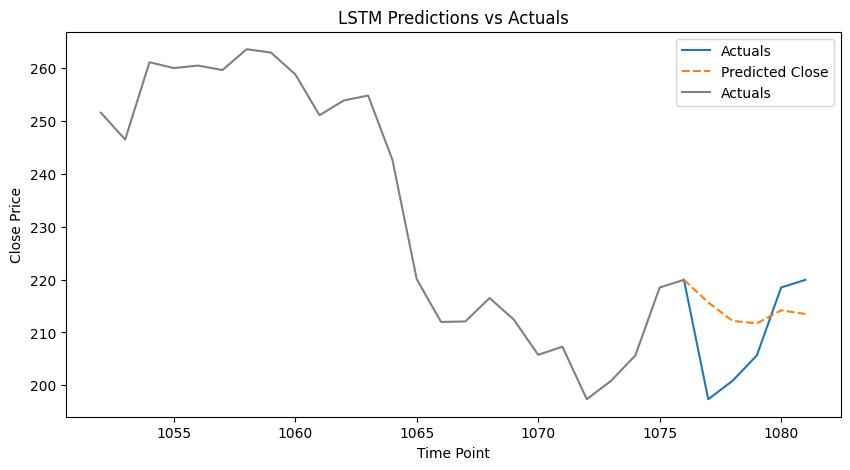

In [8]:

from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

data1 = data['Close']

# MAE
mae = mean_absolute_error(test_predict_original_np[1:], y_test_np[1:])
print(f'Mean Absolute Error: {mae}')

from sklearn.metrics import mean_absolute_error,mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    


mape = mean_absolute_percentage_error(test_predict_original_np[1:], y_test_np[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

# RMSE
rmse = np.sqrt(mean_squared_error(test_predict_original_np[1:], y_test_np[1:]))
print(f'Root Mean Squared Error: {rmse}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(test_predict_original_np[1:], y_test_np[1:])
print(f"Spearman corr: {corr}")


plt.figure(figsize=(10, 5))
plt.plot(data1.index[-6:], y_test_np, label='Actuals', marker='', linestyle='-')
plt.plot(data1.index[-6:], test_predict_original_np, label='Predicted Close', marker='', linestyle='--')
plt.plot(data1.index[-30:-5], data1[-30:-5], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('LSTM Predictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Mean Absolute Error: 7.222196609798123
Mean Absolute Percentage Error: 3.4328149126128684%
Root Mean Squared Error: 8.62205959004395
Spearman's rho (ρ): -0.6
Spearman's p_value: 0.28475697986529375


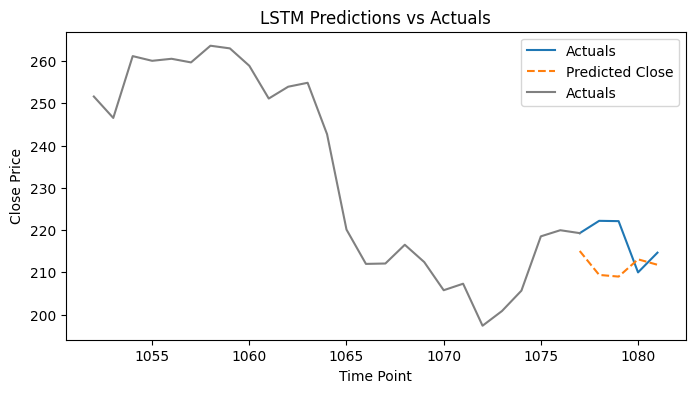

In [9]:
mae = mean_absolute_error(real_test_predict_original[0], real_y_test)
print(f'Mean Absolute Error: {mae}')

mape = mean_absolute_percentage_error(real_test_predict_original[0], real_y_test)
print(f'Mean Absolute Percentage Error: {mape}%')

# RMSE
rmse = np.sqrt(mean_squared_error(real_test_predict_original[0], real_y_test))
print(f'Root Mean Squared Error: {rmse}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(real_test_predict_original[0], real_y_test)
print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")

plt.figure(figsize=(8, 4))
plt.plot(data1.index[-5:], real_y_test, label='Actuals', marker='', linestyle='-')
plt.plot(data1.index[-5:], real_test_predict_original[0], label='Predicted Close', marker='', linestyle='--')
plt.plot(data1.index[-30:-4], data1[-30:-4], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('LSTM Predictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Close Price')
plt.legend()
plt.show()

